# HDP spell-sound analyzer

developed by Kow Kuroda (kow.kuroda@gmail.com)

History
2024/08/19 Cython を使った cy_gen_ngrams を利用可能にした
2024/09/02 n-gram 生成の generic function を導入し，コードを簡略化
2024/09/06 term の階層クラスタリングを実装
2024/10/28 (skippy) n-gram 生成処理を高速化. Cython を使わなくてもそれなりに速くなった

In [12]:
#!pip install -U pyLDAvis
#!pip install -U pandas

# HDP spell-sound analyzer

developed by Kow Kuroda (kow.kuroda@gmail.com)

This Jupyter Notebook was prepared for Kow Kuroda's paper presented at the 41st Annual Meeting of Japanese Cognitive Science Society, Tokyo (2024/10/14).

In [13]:
## imports
import os, sys
import pprint as pp
import unicodedata

In [14]:
## 一つ上の階層のファイルを見るように設定
sys.path.append(os.path.join(os.path.dirname("__file__"), '..'))

In [ ]:
## 必要に応じてCython のインストール
#!conda install cython -y

In [15]:
## Cython module の生成 (必要に応じて)
#!python clean setup.py build_ext --inplace

In [16]:
## Cython を使うかどうか
use_Cython = False
if use_Cython:
    %load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [17]:
## term settings
term_classes        = [ 'spell', 'sound' ]
term_class          = term_classes[0]
ngram_is_inclusive  = True
inclusion_degree    = None

## doc settings
max_doc_size        = 11
min_doc_size        =  3
print(f"max_doc_size: {max_doc_size}")
print(f"min_doc_size: {min_doc_size}")

### boundary handling
mark_boundaries     = True # if True, n_for_ngram needs to be one-size bigger
boundary_mark       = "#"

## term setting
term_is_skippy      = True
n_for_ngram         = 4
max_gap_ratio       = 1.0
max_gap_size        = round(max_doc_size * max_gap_ratio)
print(f"term_class: {term_class}")
print(f"term_is_skippy: {term_is_skippy}")
print(f"max_gap_size: {max_gap_size}")
print(f"n_for_ngram: {n_for_ngram}")

## symbols
gap_mark            = "…"
seg_joint           = ""

### accent handling
suppress_accents    = True
accent_marks        = [ "ˈ", "ˌ" ] 
if term_class == 'sound':
    if suppress_accents:
        accent_status = "-unaccented"
    else:
        accent_stratus = "-accented"
else:
    accent_status = ""
print(f"accent_status: {accent_status}")

## define term_type
if term_class == 'spell':
    if term_is_skippy:
        term_type = f"sp_skippy{n_for_ngram}gram"
    else:
        term_type = f"sp_{n_for_ngram}gram"
else:
    if term_is_skippy:
        term_type = f"sn_skippy{n_for_ngram}gram"
    else:
        term_type = f"sn_{n_for_ngram}gram"
print(f"term_type: {term_type}")

max_doc_size: 11
min_doc_size: 3
term_class: spell
term_is_skippy: True
max_gap_size: 11
n_for_ngram: 5
accent_status: 
term_type: sp_skippy5gram


In [18]:
## target language
## a key must be part of a file name 
target_lang_dict = {    'en_US' : 'English (US)',
                        'en_UK' : 'English (UK)',
                        'en_N_only' : 'English noun (WN)',
                        'en_V_only' : 'English verb (WN)',
                        'en_A_only' : 'English adj (WN)',
                        'en_R_only' : 'English adv (WN)',
                        'ar'    : 'Arabic',
                        'de'    : 'German',
                        'de_N_only' : 'German Nouns',
                        'de_non_N_only' : 'German Non-nouns',
                        'eo'    : 'Esperanto',
                        'es_ES' : 'Spanish (Spain)',
                        'es_MX' : 'Spanish (Mexico)',
                        'fi'    : 'Finnish',
                        'fr_FR' : 'French (France)',
                        'fr_QC' : 'French (Quebec)',
                        'is'    : 'Icelandic',
                        'ir'    : 'Irish',
                        'nl'    : 'Dutch',
                        'ro'    : 'Romanian',
                        'sw'    : 'Swahili' }
## proper language selection
target_lang_keys = [    'en_US', # 0
                        'en_UK', # 1
                        'en_N_only', # 2
                        'en_V_only', # 3
                        'en_A_only', # 4
                        'en_R_only', # 5
                        'ar', # 6
                        'de', # 7
                        'de_N_only', # 8
                        'de_non_N_only', # 9
                        'eo', 'es_ES', 'es_MX',
                        'fi', 'fr_FR', 'fr_QC',
                        'is', 'nl', 'ro', 'sw',
                        'ir' # This lacks sound
                    ]

## check
target_lang_key  = target_lang_keys[11]
print(f"target_lang_key: {target_lang_key}")
print(f"target lang: {target_lang_dict[target_lang_key]} [{target_lang_key}]")

## target_attr [effective only for Irish]
target_class = ""

#target_class = None # This causes an unrediable error
if target_lang_key == "ir":
    target_classes = [ 'adjectives', 'nouns', 'verbs' ]
    target_class = f"-{target_classes[3]}"
print(f"target_class: {target_class}")

target_lang_key: es_ES
target lang: Spanish (Spain) [es_ES]
target_class: 


In [19]:
## LDA/HDP
apply_term_filtering = True
## The following parameters need to be relatively large to prevent "Row sum not equal 1" error
term_minfreq       = 2
min_bot_size       = min_doc_size # 3
abuse_threshold    = 0.05 # larger value selects shorter units, smaller value selects longer units

# number of terms listed for a given topic
n_docs_to_show     = 15
n_terms_to_show    = 20
n_terms_to_save    = 120

# saving output
save_LDAvis          = False
save_topic_structure = False

# hierarchical clustering
hc_sampling_rate     = 0.02

In [20]:
## sampling
source_sampling           = True
source_sampling_rate      = 0.5
source_sampling_max_size  = 5000
second_sampling           = False
second_sampling_rate      = 0.7

In [21]:
## set target files
import glob
import pprint as pp

data_dir1     = "data/open-dict-ipa/data1"
data_dir2     = "data/open-dict-ipa/data1a"
data_dir3     = "data/wn3"
data_dir4     = "data/irish"
target_files  = glob.glob(f"{data_dir1}/*")
target_files2 = glob.glob(f"{data_dir2}/*")
target_files.extend(target_files2)
target_files3 = glob.glob(f"{data_dir3}/*")
target_files.extend(target_files3)
target_files4 = glob.glob(f"{data_dir4}/*")
target_files.extend(target_files4)
#
target_files = sorted([ file for file in target_files if ".csv" in file ])
pp.pprint(target_files)

['data/irish/word-irish-adjectives-spell.csv',
 'data/irish/word-irish-noun-phrases-spell.csv',
 'data/irish/word-irish-nouns-spell.csv',
 'data/irish/word-irish-possessives-spell.csv',
 'data/irish/word-irish-prepositions-spell.csv',
 'data/irish/word-irish-verbs-spell.csv',
 'data/open-dict-ipa/data1/ar.csv.gz',
 'data/open-dict-ipa/data1/de.csv.gz',
 'data/open-dict-ipa/data1/en_UK.csv.gz',
 'data/open-dict-ipa/data1/en_US.csv',
 'data/open-dict-ipa/data1/en_US.csv.gz',
 'data/open-dict-ipa/data1/eo.csv.gz',
 'data/open-dict-ipa/data1/es_ES.csv.gz',
 'data/open-dict-ipa/data1/es_MX.csv.gz',
 'data/open-dict-ipa/data1/fa.csv.gz',
 'data/open-dict-ipa/data1/fi.csv.gz',
 'data/open-dict-ipa/data1/fr_FR.csv.gz',
 'data/open-dict-ipa/data1/fr_QC.csv.gz',
 'data/open-dict-ipa/data1/is.csv.gz',
 'data/open-dict-ipa/data1/ja.csv.gz',
 'data/open-dict-ipa/data1/jam.csv.gz',
 'data/open-dict-ipa/data1/ma.csv.gz',
 'data/open-dict-ipa/data1/nb.csv.gz',
 'data/open-dict-ipa/data1/nl.csv.gz',
 '

In [22]:
## get source data from files
import pandas as pd
import gzip
#target_language_key = "en_US" # can be changed to get other languages
#if target_class != "" or target_class is not None:
if target_class != "":
    target_file = [ f for f in target_files if target_lang_key in f and target_class in f ][0]
else:
    target_file = [ f for f in target_files if target_lang_key in f ][0]
print(f"processing: {target_file}")
##
if target_lang_key == "ir":
    col_names = ['spell', 'POS']
else:
    col_names = ['spell', 'sound']

##
if target_file.endswith(".gz"):
    with gzip.open(target_file, "rt") as f:
        raw_df = pd.read_csv(f, encoding = 'utf8', header = None, names = col_names )
else:
    with open(target_file, "rt") as f:
        raw_df = pd.read_csv(f, encoding = 'utf8', header = None, names = col_names )

## normalize characters
raw_df['spell'] = raw_df['spell'].apply(lambda x: unicodedata.normalize('NFC', str(x)))

## modify sound
try:
    sounds = raw_df['sound'].apply(lambda x: x.strip('/') )
    sounds = [ x.split("/,")[0] for x in sounds ] # picks up only the first of multiple entries
    raw_df['sound'] = sounds
except (AttributeError, KeyError):
    pass
#
raw_df.sample(10)

processing: data/open-dict-ipa/data1/es_ES.csv.gz


spell            sound
254470      encañonaren      eŋkaɲonaɾen
91872          bilítero        biˈliteɾo
508465    repiquetearen     repiketeaɾen
93689         bocelares        boθelaɾes
164041      desangrabas      desaŋgɾaβas
240019  emborrascásemos  emboraˈskasemos
303262           esfumó          esfuˈmo
92170          birremes          biremes
263352        encubadas        eŋkuβaðas
348499            Godoy            goðoj

In [23]:
## source sampling
len(raw_df)
if source_sampling:
	print(f"source sampling applied")
	if len(raw_df) >= source_sampling_max_size:
		raw_df = raw_df.sample(source_sampling_max_size)
	else:
		raw_df = raw_df.sample(round(len(raw_df) * source_sampling_rate))
## remove accent marking
if suppress_accents:
	try:
		raw_df['sound'] = raw_df['sound'].apply(lambda x: "".join([ y for y in list(x) if y not in accent_marks ]))
	except KeyError:
		pass
## add boudary marks
if mark_boundaries:
	raw_df['spell'] = raw_df['spell'].apply(lambda x: f"{boundary_mark}{x}{boundary_mark}")
	try:
		raw_df['sound'] = raw_df['sound'].apply(lambda x: f"{boundary_mark}{x}{boundary_mark}")
	except KeyError:
		pass
#
print(raw_df)

source sampling applied
                   spell             sound
113384     #centrároslo#     #θentɾaɾozlo#
418177       #minorados#       #minoɾaðos#
159451    #desabotonará#    #desaβotonaɾa#
572284    #trascendería#    #tɾasθendeɾia#
581         #abandonará#      #aβandonaɾa#
...                  ...               ...
64377         #armónica#        #aɾmonika#
37435       #aljofifaba#      #alxofifaβa#
82260        #avocaseis#       #aβokaseis#
341101       #friéndome#       #fɾiendome#
21247   #adscribiéndolo#  #aðskɾiβjendolo#

[5000 rows x 2 columns]


In [24]:
## generate 1-grams for spell and sound
## spell
raw_df['sp_1gram'] = raw_df['spell'].apply(lambda x: list(str(x)))
# add column of size
raw_df['sp_size'] = raw_df['sp_1gram'].apply(lambda x: len(x))
# add column of count of '-' inside
raw_df['hyphen'] = raw_df['sp_1gram'].apply(lambda x: list(x).count("-"))
# add column of count of '.' inside
raw_df['period'] = raw_df['sp_1gram'].apply(lambda x: list(x).count("."))
## sound
# takes the first entry, removes '/' around
try:
    raw_df['sn_1gram'] = raw_df['sound'].apply(lambda x: list(x) )
except (TypeError, KeyError):
    pass
# add column of size
try:
    raw_df['sn_size'] = raw_df['sn_1gram'].apply(lambda x: len(x))
except KeyError:
    pass
## check
raw_df

spell             sound  \
113384     #centrároslo#     #θentɾaɾozlo#   
418177       #minorados#       #minoɾaðos#   
159451    #desabotonará#    #desaβotonaɾa#   
572284    #trascendería#    #tɾasθendeɾia#   
581         #abandonará#      #aβandonaɾa#   
...                  ...               ...   
64377         #armónica#        #aɾmonika#   
37435       #aljofifaba#      #alxofifaβa#   
82260        #avocaseis#       #aβokaseis#   
341101       #friéndome#       #fɾiendome#   
21247   #adscribiéndolo#  #aðskɾiβjendolo#   

                                                sp_1gram  sp_size  hyphen  \
113384           [#, c, e, n, t, r, á, r, o, s, l, o, #]       13       0   
418177                 [#, m, i, n, o, r, a, d, o, s, #]       11       0   
159451        [#, d, e, s, a, b, o, t, o, n, a, r, á, #]       14       0   
572284        [#, t, r, a, s, c, e, n, d, e, r, í, a, #]       14       0   
581                 [#, a, b, a, n, d, o, n, a, r, á, #]       12       0   
...                                                  ...      ...     ...   
64377                     [#, a, r, m, ó, n, i, c, a, #]       10       0   
37435               [#, a, l, j, o, f, i, f, a, b, a, #]       12       0   
82260                  [#, a, v, o, c, a, s, e, i, s, #]       11       0   
341101                 [#, f, r, i, é, n, d, o, m, e, #]       11       0   
21247   [#, a, d, s, c, r, i, b, i, é, n, d, o, l, o, #]       16       0   

        period                                          sn_1gram  sn_size  
113384       0           [#, θ, e, n, t, ɾ, a, ɾ, o, z, l, o, #]       13  
418177       0                 [#, m, i, n, o, ɾ, a, ð, o, s, #]       11  
159451       0        [#, d, e, s, a, β, o, t, o, n, a, ɾ, a, #]       14  
572284       0        [#, t, ɾ, a, s, θ, e, n, d, e, ɾ, i, a, #]       14  
581          0              [#, a, β, a, n, d, o, n, a, ɾ, a, #]       12  
...        ...                                               ...      ...  
64377        0                    [#, a, ɾ, m, o, n, i, k, a, #]       10  
37435        0              [#, a, l, x, o, f, i, f, a, β, a, #]       12  
82260        0                 [#, a, β, o, k, a, s, e, i, s, #]       11  
341101       0                 [#, f, ɾ, i, e, n, d, o, m, e, #]       11  
21247        0  [#, a, ð, s, k, ɾ, i, β, j, e, n, d, o, l, o, #]       16  

[5000 rows x 8 columns]

In [25]:
## filtering raw_data by size
print(f"term_type: {term_type}")
if "sp_" in term_type:
    df_filtered = raw_df[ (raw_df['sp_size'] <= max_doc_size) & (raw_df['sp_size'] >= min_doc_size) & (raw_df['hyphen'] == 0) & (raw_df['period'] == 0) ]
else:
    df_filtered = raw_df[ (raw_df['sn_size'] <= max_doc_size) & (raw_df['sn_size'] >= min_doc_size) ]
#
df_filtered

term_type: sp_skippy5gram


spell        sound                           sp_1gram  sp_size  \
418177  #minorados#  #minoɾaðos#  [#, m, i, n, o, r, a, d, o, s, #]       11   
125147  #colmaseis#  #kolmaseis#  [#, c, o, l, m, a, s, e, i, s, #]       11   
549852  #suavizare#  #swaβiθaɾe#  [#, s, u, a, v, i, z, a, r, e, #]       11   
388345         #la#         #la#                       [#, l, a, #]        4   
519237   #reusando#   #reusando#     [#, r, e, u, s, a, n, d, o, #]       10   
...             ...          ...                                ...      ...   
399023     #lometa#     #lometa#           [#, l, o, m, e, t, a, #]        8   
95685     #borrado#     #boraðo#        [#, b, o, r, r, a, d, o, #]        9   
64377    #armónica#   #aɾmonika#     [#, a, r, m, ó, n, i, c, a, #]       10   
82260   #avocaseis#  #aβokaseis#  [#, a, v, o, c, a, s, e, i, s, #]       11   
341101  #friéndome#  #fɾiendome#  [#, f, r, i, é, n, d, o, m, e, #]       11   

        hyphen  period                           sn_1gram  sn_size  
418177       0       0  [#, m, i, n, o, ɾ, a, ð, o, s, #]       11  
125147       0       0  [#, k, o, l, m, a, s, e, i, s, #]       11  
549852       0       0  [#, s, w, a, β, i, θ, a, ɾ, e, #]       11  
388345       0       0                       [#, l, a, #]        4  
519237       0       0     [#, r, e, u, s, a, n, d, o, #]       10  
...        ...     ...                                ...      ...  
399023       0       0           [#, l, o, m, e, t, a, #]        8  
95685        0       0           [#, b, o, r, a, ð, o, #]        8  
64377        0       0     [#, a, ɾ, m, o, n, i, k, a, #]       10  
82260        0       0  [#, a, β, o, k, a, s, e, i, s, #]       11  
341101       0       0  [#, f, ɾ, i, e, n, d, o, m, e, #]       11  

[1830 rows x 8 columns]

In [26]:
## define df after second sampling if any
len(df_filtered)
if second_sampling:
    df = df_filtered.sample(round(len(df_filtered) * second_sampling_rate))
else:
    df = df_filtered
len(df)

1830

In [27]:
## generic function for n-gram generation
def add_ngram_to_df (dfx, n_for_ngram: int, skippy: bool, prefix: str = "", seg_joint: str = "", missing_mark: str = gap_mark, max_distance = None, inclusive: bool = ngram_is_inclusive, inclusion_degree = None, use_Cython: bool = False, check: bool = False):
    """
    generic function for adding n-gram column to df with a specified n for ngram
    """
    ## variables
    source_var = f"{prefix}1gram"
    print(f"source_var: {source_var}")
    if skippy:
        target_var = f"{prefix}skippy{n_for_ngram}gram"
    else:
        target_var = f"{prefix}{n_for_ngram}gram"
    print(f"target_var: {target_var}")
    
    ##
    unigrams = dfx[source_var]
    if use_Cython:
        import cy_gen_ngrams
        if skippy:
            #ngrams = [ [seg_joint.join(x) for x in cy_gen_ngrams.cy_gen_skippy_ngrams(x, n = n_for_ngram, missing_mark = missing_mark, max_distance = max_distance, check = check)] for x in unigrams ]
            ## The following replaces the above
            ngrams = unigrams.apply(lambda x: cy_gen_ngrams.gen_skippy_ngrams(x, n = n_for_ngram, sep = seg_joint, missing_mark = missing_mark, max_distance = max_distance, check = check) )
            
        else:
            #ngrams = [ [seg_joint.join(x) for x in cy_gen_ngrams.cy_gen_ngrams(x, n = n_for_ngram, sep = seg_joint, check = check)] for x in unigrams ]
            ## The following replaces the above
            ngrams = unigrams.apply(lambda x: cy_gen_ngrams.gen_ngrams(x, n = n_for_ngram, sep = seg_joint, check = check) )
    else:
        import gen_ngrams
        if skippy:
            #ngrams = [ gen_ngrams.gen_skippy_ngrams(x, n = n_for_ngram, sep = seg_joint, missing_mark = missing_mark, max_distance = max_distance, check = check) for x in unigrams ]
            ngrams = unigrams.apply(lambda x: gen_ngrams.gen_skippy_ngrams(x, n = n_for_ngram, sep = seg_joint, missing_mark = missing_mark, max_distance = max_distance, check = check) )
        else:
            #ngrams = [ gen_ngrams.gen_ngrams(x, n = n_for_ngram, sep = seg_joint, check = check) for x in unigrams ]
            ngrams = unigrams.apply(lambda x: gen_ngrams.gen_ngrams(x, n = n_for_ngram, sep = seg_joint, check = check) )
    ## 包括的 n-gramの生成
    if inclusive:
        if inclusion_degree is None:
            min_size = 1
        else:
            min_size = (n_for_ngram - inclusion_degree)
        print(f"min_size: {min_size}")
        assert min_size >= 0
        if skippy and n_for_ngram > 2:
            supplement_var = f"{prefix}skippy{n_for_ngram - 1}gram"
        else:
            supplement_var = f"{prefix}{n_for_ngram - 1}gram"
        print(f"supplement_var: {supplement_var}")
        for i, g in enumerate(ngrams):
            supplement = [ x for x in list(dfx[supplement_var])[i] if len(x) >= min_size ]
            if len(supplement) > 0:
                g.extend(supplement)
    ## 変数の追加
    dfx[target_var] = ngrams
    ## check result
    print(dfx[target_var])

# Spell

In [28]:
## spell 2grams
add_ngram_to_df(df, n_for_ngram = 2, prefix = "sp_", seg_joint = "", skippy = False, inclusive = True, inclusion_degree = inclusion_degree, check = False)

source_var: sp_1gram
target_var: sp_2gram
min_size: 1
supplement_var: sp_1gram
418177    [#m, mi, in, no, or, ra, ad, do, os, s#, #, m,...
125147    [#c, co, ol, lm, ma, as, se, ei, is, s#, #, c,...
549852    [#s, su, ua, av, vi, iz, za, ar, re, e#, #, s,...
388345                             [#l, la, a#, #, l, a, #]
519237    [#r, re, eu, us, sa, an, nd, do, o#, #, r, e, ...
                                ...                        
399023    [#l, lo, om, me, et, ta, a#, #, l, o, m, e, t,...
95685     [#b, bo, or, rr, ra, ad, do, o#, #, b, o, r, r...
64377     [#a, ar, rm, mó, ón, ni, ic, ca, a#, #, a, r, ...
82260     [#a, av, vo, oc, ca, as, se, ei, is, s#, #, a,...
341101    [#f, fr, ri, ié, én, nd, do, om, me, e#, #, f,...
Name: sp_2gram, Length: 1830, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_47205/2567272026.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


In [29]:
## frequencies of 2grams
ngram_is_skippy = False
n_now = 2
prefix = "sp_"
if ngram_is_skippy:
    skippiness = "skippy"
else:
    skippiness = "" 
var_name = f'{prefix}{skippiness}{n_now}gram'
G = [ ]
[ G.extend([x for x in L if len(x.replace(gap_mark, "")) == n_now]) for L in df[var_name] ]

import collections
collections.Counter(G).most_common(30)

[('s#', 584),
 ('ar', 476),
 ('as', 328),
 ('es', 291),
 ('en', 289),
 ('a#', 284),
 ('ra', 274),
 ('#a', 268),
 ('re', 267),
 ('an', 248),
 ('n#', 241),
 ('#e', 238),
 ('e#', 216),
 ('os', 204),
 ('ad', 194),
 ('o#', 187),
 ('la', 172),
 ('ta', 158),
 ('is', 155),
 ('#c', 153),
 ('ca', 152),
 ('te', 141),
 ('#r', 140),
 ('er', 139),
 ('se', 136),
 ('ba', 134),
 ('al', 131),
 ('ab', 131),
 ('de', 131),
 ('#d', 126)]

In [30]:
## spell 3grams
add_ngram_to_df(df, n_for_ngram = 3, prefix = "sp_", skippy = False, inclusive = True, inclusion_degree = inclusion_degree, check = False)

source_var: sp_1gram
target_var: sp_3gram
min_size: 1
supplement_var: sp_2gram
418177    [#mi, min, ino, nor, ora, rad, ado, dos, os#, ...
125147    [#co, col, olm, lma, mas, ase, sei, eis, is#, ...
549852    [#su, sua, uav, avi, viz, iza, zar, are, re#, ...
388345                   [#la, la#, #l, la, a#, #, l, a, #]
519237    [#re, reu, eus, usa, san, and, ndo, do#, #r, r...
                                ...                        
399023    [#lo, lom, ome, met, eta, ta#, #l, lo, om, me,...
95685     [#bo, bor, orr, rra, rad, ado, do#, #b, bo, or...
64377     [#ar, arm, rmó, món, óni, nic, ica, ca#, #a, a...
82260     [#av, avo, voc, oca, cas, ase, sei, eis, is#, ...
341101    [#fr, fri, rié, ién, énd, ndo, dom, ome, me#, ...
Name: sp_3gram, Length: 1830, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_47205/2567272026.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


In [31]:
## frequencies of 3grams
ngram_is_skippy = False
n_now = 3
prefix = "sp_"
if ngram_is_skippy:
    skippiness = "skippy"
else:
    skippiness = "" 
var_name = f'{prefix}{skippiness}{n_now}gram'
G = [ ]
[ G.extend([x for x in L if len(x.replace(gap_mark, "")) == n_now]) for L in df[var_name] ]

import collections
collections.Counter(G).most_common(30)

[('as#', 187),
 ('os#', 144),
 ('es#', 129),
 ('#en', 108),
 ('an#', 104),
 ('is#', 101),
 ('en#', 90),
 ('#de', 88),
 ('#re', 87),
 ('ara', 85),
 ('aba', 85),
 ('are', 83),
 ('ase', 79),
 ('do#', 69),
 ('des', 61),
 ('ado', 59),
 ('ará', 58),
 ('ra#', 57),
 ('mos', 57),
 ('#es', 55),
 ('ad#', 53),
 ('se#', 52),
 ('ada', 52),
 ('#co', 50),
 ('#ca', 48),
 ('ear', 48),
 ('ría', 47),
 ('ar#', 47),
 ('ran', 46),
 ('te#', 45)]

In [32]:
## spell 4grams
add_ngram_to_df(df, n_for_ngram = 4, prefix = "sp_", skippy = False, inclusive = True, inclusion_degree = inclusion_degree, check = False)

/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_47205/2567272026.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


source_var: sp_1gram
target_var: sp_4gram
min_size: 1
supplement_var: sp_3gram
418177    [#min, mino, inor, nora, orad, rado, ados, dos...
125147    [#col, colm, olma, lmas, mase, asei, seis, eis...
549852    [#sua, suav, uavi, aviz, viza, izar, zare, are...
388345             [#la#, #la, la#, #l, la, a#, #, l, a, #]
519237    [#reu, reus, eusa, usan, sand, ando, ndo#, #re...
                                ...                        
399023    [#lom, lome, omet, meta, eta#, #lo, lom, ome, ...
95685     [#bor, borr, orra, rrad, rado, ado#, #bo, bor,...
64377     [#arm, armó, rmón, móni, ónic, nica, ica#, #ar...
82260     [#avo, avoc, voca, ocas, case, asei, seis, eis...
341101    [#fri, frié, rién, iénd, éndo, ndom, dome, ome...
Name: sp_4gram, Length: 1830, dtype: object


In [33]:
## spell 5grams
add_ngram_to_df(df, n_for_ngram = 5, prefix = "sp_", skippy = False, inclusive = True, inclusion_degree = inclusion_degree, check = False)

source_var: sp_1gram
target_var: sp_5gram
min_size: 1
supplement_var: sp_4gram
418177    [#mino, minor, inora, norad, orado, rados, ado...
125147    [#colm, colma, olmas, lmase, masei, aseis, sei...
549852    [#suav, suavi, uaviz, aviza, vizar, izare, zar...
388345    [#, l, a, #, #la#, #la, la#, #l, la, a#, #, l,...
519237    [#reus, reusa, eusan, usand, sando, ando#, #re...
                                ...                        
399023    [#lome, lomet, ometa, meta#, #lom, lome, omet,...
95685     [#borr, borra, orrad, rrado, rado#, #bor, borr...
64377     [#armó, armón, rmóni, mónic, ónica, nica#, #ar...
82260     [#avoc, avoca, vocas, ocase, casei, aseis, sei...
341101    [#frié, frién, riénd, iéndo, éndom, ndome, dom...
Name: sp_5gram, Length: 1830, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_47205/2567272026.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


In [34]:
## spell skippy 2grams
add_ngram_to_df(df, n_for_ngram = 2, prefix = "sp_", skippy = True, inclusive = ngram_is_inclusive, inclusion_degree = inclusion_degree, check = False)

source_var: sp_1gram
target_var: sp_skippy2gram
min_size: 1
supplement_var: sp_1gram
418177    [#m, #…i, #…n, #…o, #…r, #…a, #…d, #…o, #…s, #...
125147    [#c, #…o, #…l, #…m, #…a, #…s, #…e, #…i, #…s, #...
549852    [#s, #…u, #…a, #…v, #…i, #…z, #…a, #…r, #…e, #...
388345    [#l, #…a, #…#, #…#la#, #…#la, #…la#, #…#l, #…l...
519237    [#r, #…e, #…u, #…s, #…a, #…n, #…d, #…o, #…#, r...
                                ...                        
399023    [#l, #…o, #…m, #…e, #…t, #…a, #…#, lo, l…m, l…...
95685     [#b, #…o, #…r, #…r, #…a, #…d, #…o, #…#, bo, b…...
64377     [#a, #…r, #…m, #…ó, #…n, #…i, #…c, #…a, #…#, a...
82260     [#a, #…v, #…o, #…c, #…a, #…s, #…e, #…i, #…s, #...
341101    [#f, #…r, #…i, #…é, #…n, #…d, #…o, #…m, #…e, #...
Name: sp_skippy2gram, Length: 1830, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_47205/2567272026.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


In [35]:
## frequencies of skippy 2grams
ngram_is_skippy = True
n_now = 2
prefix = "sp_"
if ngram_is_skippy:
    skippiness = "skippy"
else:
    skippiness = "" 
var_name = f'{prefix}{skippiness}{n_now}gram'
G = [ ]
[ G.extend([x for x in L if len(x.replace(gap_mark, "")) == n_now]) for L in df[var_name] ]

import collections
collections.Counter(G).most_common(30)

[('#…a', 2016),
 ('a…#', 1999),
 ('#…#', 1840),
 ('e…#', 1413),
 ('#…e', 1391),
 ('r…#', 1206),
 ('#…r', 1128),
 ('#…s', 1080),
 ('a…a', 1065),
 ('#…o', 925),
 ('#…n', 898),
 ('i…#', 852),
 ('#…i', 794),
 ('e…a', 792),
 ('o…#', 771),
 ('n…#', 679),
 ('a…e', 643),
 ('a…s', 641),
 ('s#', 584),
 ('l…#', 583),
 ('s…#', 578),
 ('r…a', 578),
 ('c…#', 572),
 ('t…#', 556),
 ('#…l', 528),
 ('d…#', 494),
 ('r…s', 492),
 ('e…s', 480),
 ('ar', 476),
 ('o…a', 466)]

In [36]:
## spell skippy 3grams
add_ngram_to_df(df, n_for_ngram = 3, prefix = "sp_", skippy = True, inclusive = ngram_is_inclusive, inclusion_degree = inclusion_degree, check = False)

source_var: sp_1gram
target_var: sp_skippy3gram
min_size: 1
supplement_var: sp_skippy2gram
418177    [#mi, #m…n, #m…o, #m…r, #m…a, #m…d, #m…o, #m…s...
125147    [#co, #c…l, #c…m, #c…a, #c…s, #c…e, #c…i, #c…s...
549852    [#su, #s…a, #s…v, #s…i, #s…z, #s…a, #s…r, #s…e...
388345    [#la, #l…#, #l…#la#, #l…#la, #l…la#, #l…#l, #l...
519237    [#re, #r…u, #r…s, #r…a, #r…n, #r…d, #r…o, #r…#...
                                ...                        
399023    [#lo, #l…m, #l…e, #l…t, #l…a, #l…#, #…om, #…o…...
95685     [#bo, #b…r, #b…r, #b…a, #b…d, #b…o, #b…#, #…or...
64377     [#ar, #a…m, #a…ó, #a…n, #a…i, #a…c, #a…a, #a…#...
82260     [#av, #a…o, #a…c, #a…a, #a…s, #a…e, #a…i, #a…s...
341101    [#fr, #f…i, #f…é, #f…n, #f…d, #f…o, #f…m, #f…e...
Name: sp_skippy3gram, Length: 1830, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_47205/2567272026.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


In [37]:
## frequencies of skippy 3grams
ngram_is_skippy = True
n_now = 3
prefix = "sp_"
if ngram_is_skippy:
    skippiness = "skippy"
else:
    skippiness = "" 
var_name = f'{prefix}{skippiness}{n_now}gram'
G = [ ]
[ G.extend([x for x in L if len(x.replace(gap_mark, "")) == n_now]) for L in df[var_name] ]

import collections
collections.Counter(G).most_common(30)

[('#…a…#', 1731),
 ('#…e…#', 1175),
 ('#…r…#', 1066),
 ('#…i…#', 794),
 ('#…a…a', 789),
 ('a…a…#', 782),
 ('#…o…#', 738),
 ('#…n…#', 656),
 ('e…a…#', 634),
 ('#…s#', 584),
 ('#…e…a', 556),
 ('a…s#', 515),
 ('#…l…#', 515),
 ('#…s…#', 496),
 ('#…a…s', 492),
 ('#…a…e', 485),
 ('#…ar', 458),
 ('#…t…#', 455),
 ('a…e…#', 442),
 ('r…a…#', 438),
 ('#…o…a', 429),
 ('ar…#', 429),
 ('#…r…a', 429),
 ('#…r…s', 423),
 ('#…c…#', 419),
 ('#…u…#', 384),
 ('r…s#', 380),
 ('#…e…s', 380),
 ('e…r…#', 377),
 ('#…i…a', 373)]

In [38]:
## spell skippy 4grams
add_ngram_to_df(df, n_for_ngram = 4, prefix = "sp_", skippy = True, inclusive = ngram_is_inclusive, inclusion_degree = inclusion_degree, check = False)

source_var: sp_1gram
target_var: sp_skippy4gram
min_size: 1
supplement_var: sp_skippy3gram
418177    [#min, #mi…o, #mi…r, #mi…a, #mi…d, #mi…o, #mi…...
125147    [#col, #co…m, #co…a, #co…s, #co…e, #co…i, #co…...
549852    [#sua, #su…v, #su…i, #su…z, #su…a, #su…r, #su…...
388345    [#la#, #la…#la#, #la…#la, #la…la#, #la…#l, #la...
519237    [#reu, #re…s, #re…a, #re…n, #re…d, #re…o, #re…...
                                ...                        
399023    [#lom, #lo…e, #lo…t, #lo…a, #lo…#, #l…me, #l…m...
95685     [#bor, #bo…r, #bo…a, #bo…d, #bo…o, #bo…#, #b…r...
64377     [#arm, #ar…ó, #ar…n, #ar…i, #ar…c, #ar…a, #ar…...
82260     [#avo, #av…c, #av…a, #av…s, #av…e, #av…i, #av…...
341101    [#fri, #fr…é, #fr…n, #fr…d, #fr…o, #fr…m, #fr…...
Name: sp_skippy4gram, Length: 1830, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_47205/2567272026.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


In [39]:
## frequencies of skippy 4grams
ngram_is_skippy = True
n_now = 4
prefix = "sp_"
if ngram_is_skippy:
    skippiness = "skippy"
else:
    skippiness = "" 
var_name = f'{prefix}{skippiness}{n_now}gram'
G = [ ]
[ G.extend([x for x in L if len(x.replace(gap_mark, "")) == n_now]) for L in df[var_name] ]

import collections
collections.Counter(G).most_common(30)

[('#…a…a…#', 546),
 ('#…a…s#', 423),
 ('#…e…a…#', 423),
 ('#…ar…#', 411),
 ('#…r…s#', 342),
 ('#…o…a…#', 323),
 ('#…r…a…#', 320),
 ('#…a…e…#', 313),
 ('#…e…s#', 305),
 ('#…n…a…#', 279),
 ('#…i…a…#', 272),
 ('#…e…r…#', 264),
 ('#…a…a#', 244),
 ('#a…a…#', 236),
 ('#…e…e…#', 217),
 ('#e…a…#', 211),
 ('#…a…i…#', 209),
 ('#…o…e…#', 205),
 ('#…i…s#', 199),
 ('#…ra…#', 195),
 ('#…e…i…#', 191),
 ('#…as#', 187),
 ('#…u…a…#', 186),
 ('#…a…r…#', 186),
 ('#…l…a…#', 184),
 ('#…s…a…#', 184),
 ('#…a…n#', 178),
 ('#…r…e…#', 177),
 ('#…a…as', 177),
 ('#…a…o…#', 176)]

In [40]:
## spell skippy 5grams
add_ngram_to_df(df, n_for_ngram = 5, prefix = "sp_", skippy = True, inclusive = ngram_is_inclusive, inclusion_degree = inclusion_degree, check = False)

source_var: sp_1gram
target_var: sp_skippy5gram
min_size: 1
supplement_var: sp_skippy4gram
418177    [#mino, #min…r, #min…a, #min…d, #min…o, #min…s...
125147    [#colm, #col…a, #col…s, #col…e, #col…i, #col…s...
549852    [#suav, #sua…i, #sua…z, #sua…a, #sua…r, #sua…e...
388345    [#la##la#, #la#…#la, #la#…la#, #la#…#l, #la#…l...
519237    [#reus, #reu…a, #reu…n, #reu…d, #reu…o, #reu…#...
                                ...                        
399023    [#lome, #lom…t, #lom…a, #lom…#, #lo…et, #lo…e…...
95685     [#borr, #bor…a, #bor…d, #bor…o, #bor…#, #bo…ra...
64377     [#armó, #arm…n, #arm…i, #arm…c, #arm…a, #arm…#...
82260     [#avoc, #avo…a, #avo…s, #avo…e, #avo…i, #avo…s...
341101    [#frié, #fri…n, #fri…d, #fri…o, #fri…m, #fri…e...
Name: sp_skippy5gram, Length: 1830, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_47205/2567272026.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


In [41]:
## frequencies of skippy 5grams
ngram_is_skippy = True
n_now = 5
prefix = "sp_"
if ngram_is_skippy:
    skippiness = "skippy"
else:
    skippiness = "" 
var_name = f'{prefix}{skippiness}{n_now}gram'
G = [ ]
[ G.extend([x for x in L if len(x.replace(gap_mark, "")) == n_now]) for L in df[var_name] ]

import collections
collections.Counter(G).most_common(30)

[('#…a…as#', 146),
 ('#…ar…s#', 125),
 ('#…e…ar…#', 102),
 ('#…a…ar…#', 101),
 ('#en…a…#', 97),
 ('#…a…os#', 92),
 ('#…a…a…s#', 91),
 ('#…a…an#', 86),
 ('#…r…as#', 83),
 ('#…e…r…s#', 81),
 ('#…a…es#', 81),
 ('#…o…ar…#', 76),
 ('#…e…as#', 75),
 ('#…e…os#', 74),
 ('#re…a…#', 73),
 ('#…ar…a…#', 72),
 ('#de…a…#', 71),
 ('#…a…e…s#', 70),
 ('#…r…a…s#', 70),
 ('#…r…os#', 69),
 ('#…i…ar…#', 68),
 ('#…ar…n#', 68),
 ('#…e…a…s#', 68),
 ('#…n…ar…#', 65),
 ('#a…ar…#', 65),
 ('#…a…is#', 63),
 ('#…r…ar…#', 62),
 ('#…a…a…a…#', 61),
 ('#a…a…s#', 61),
 ('#…e…a…a…#', 60)]

In [42]:
## check result
target_vars = [ 'spell' ]
target_vars.extend([ f"sp_{i}gram" for i in range(1,6) ])
target_vars.extend([ f"sp_skippy{i}gram" for i in range(2,6) ])
df[target_vars]

spell                                           sp_1gram  \
418177  #minorados#                  [#, m, i, n, o, r, a, d, o, s, #]   
125147  #colmaseis#                  [#, c, o, l, m, a, s, e, i, s, #]   
549852  #suavizare#                  [#, s, u, a, v, i, z, a, r, e, #]   
388345         #la#  [#, l, a, #, #la#, #la, la#, #l, la, a#, #, l,...   
519237   #reusando#                     [#, r, e, u, s, a, n, d, o, #]   
...             ...                                                ...   
399023     #lometa#                           [#, l, o, m, e, t, a, #]   
95685     #borrado#                        [#, b, o, r, r, a, d, o, #]   
64377    #armónica#                     [#, a, r, m, ó, n, i, c, a, #]   
82260   #avocaseis#                  [#, a, v, o, c, a, s, e, i, s, #]   
341101  #friéndome#                  [#, f, r, i, é, n, d, o, m, e, #]   

                                                 sp_2gram  \
418177  [#m, mi, in, no, or, ra, ad, do, os, s#, #, m,...   
125147  [#c, co, ol, lm, ma, as, se, ei, is, s#, #, c,...   
549852  [#s, su, ua, av, vi, iz, za, ar, re, e#, #, s,...   
388345                           [#l, la, a#, #, l, a, #]   
519237  [#r, re, eu, us, sa, an, nd, do, o#, #, r, e, ...   
...                                                   ...   
399023  [#l, lo, om, me, et, ta, a#, #, l, o, m, e, t,...   
95685   [#b, bo, or, rr, ra, ad, do, o#, #, b, o, r, r...   
64377   [#a, ar, rm, mó, ón, ni, ic, ca, a#, #, a, r, ...   
82260   [#a, av, vo, oc, ca, as, se, ei, is, s#, #, a,...   
341101  [#f, fr, ri, ié, én, nd, do, om, me, e#, #, f,...   

                                                 sp_3gram  \
418177  [#mi, min, ino, nor, ora, rad, ado, dos, os#, ...   
125147  [#co, col, olm, lma, mas, ase, sei, eis, is#, ...   
549852  [#su, sua, uav, avi, viz, iza, zar, are, re#, ...   
388345                 [#la, la#, #l, la, a#, #, l, a, #]   
519237  [#re, reu, eus, usa, san, and, ndo, do#, #r, r...   
...                                                   ...   
399023  [#lo, lom, ome, met, eta, ta#, #l, lo, om, me,...   
95685   [#bo, bor, orr, rra, rad, ado, do#, #b, bo, or...   
64377   [#ar, arm, rmó, món, óni, nic, ica, ca#, #a, a...   
82260   [#av, avo, voc, oca, cas, ase, sei, eis, is#, ...   
341101  [#fr, fri, rié, ién, énd, ndo, dom, ome, me#, ...   

                                                 sp_4gram  \
418177  [#min, mino, inor, nora, orad, rado, ados, dos...   
125147  [#col, colm, olma, lmas, mase, asei, seis, eis...   
549852  [#sua, suav, uavi, aviz, viza, izar, zare, are...   
388345           [#la#, #la, la#, #l, la, a#, #, l, a, #]   
519237  [#reu, reus, eusa, usan, sand, ando, ndo#, #re...   
...                                                   ...   
399023  [#lom, lome, omet, meta, eta#, #lo, lom, ome, ...   
95685   [#bor, borr, orra, rrad, rado, ado#, #bo, bor,...   
64377   [#arm, armó, rmón, móni, ónic, nica, ica#, #ar...   
82260   [#avo, avoc, voca, ocas, case, asei, seis, eis...   
341101  [#fri, frié, rién, iénd, éndo, ndom, dome, ome...   

                                                 sp_5gram  \
418177  [#mino, minor, inora, norad, orado, rados, ado...   
125147  [#colm, colma, olmas, lmase, masei, aseis, sei...   
549852  [#suav, suavi, uaviz, aviza, vizar, izare, zar...   
388345  [#, l, a, #, #la#, #la, la#, #l, la, a#, #, l,...   
519237  [#reus, reusa, eusan, usand, sando, ando#, #re...   
...                                                   ...   
399023  [#lome, lomet, ometa, meta#, #lom, lome, omet,...   
95685   [#borr, borra, orrad, rrado, rado#, #bor, borr...   
64377   [#armó, armón, rmóni, mónic, ónica, nica#, #ar...   
82260   [#avoc, avoca, vocas, ocase, casei, aseis, sei...   
341101  [#frié, frién, riénd, iéndo, éndom, ndome, dom...   

                                           sp_skippy2gram  \
418177  [#m, #…i, #…n, #…o, #…r, #…a, #…d, #…o, #…s, #...   
125147  [#c, #…o, #…l, #…m, #…a, #…s, #…e, #…i, #…s, #...   
549852  [#

# Sound

In [43]:
## sound 2grams
add_ngram_to_df(df, n_for_ngram = 2, skippy = False, prefix = "sn_", inclusive = True, inclusion_degree = inclusion_degree, check = False)

source_var: sn_1gram
target_var: sn_2gram
min_size: 1
supplement_var: sn_1gram
418177    [#m, mi, in, no, oɾ, ɾa, að, ðo, os, s#, #, m,...
125147    [#k, ko, ol, lm, ma, as, se, ei, is, s#, #, k,...
549852    [#s, sw, wa, aβ, βi, iθ, θa, aɾ, ɾe, e#, #, s,...
388345                             [#l, la, a#, #, l, a, #]
519237    [#r, re, eu, us, sa, an, nd, do, o#, #, r, e, ...
                                ...                        
399023    [#l, lo, om, me, et, ta, a#, #, l, o, m, e, t,...
95685     [#b, bo, or, ra, að, ðo, o#, #, b, o, r, a, ð,...
64377     [#a, aɾ, ɾm, mo, on, ni, ik, ka, a#, #, a, ɾ, ...
82260     [#a, aβ, βo, ok, ka, as, se, ei, is, s#, #, a,...
341101    [#f, fɾ, ɾi, ie, en, nd, do, om, me, e#, #, f,...
Name: sn_2gram, Length: 1830, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_47205/2567272026.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


In [44]:
## sound 3grams
add_ngram_to_df(df, n_for_ngram = 3, skippy = False, prefix = "sn_", inclusive = True, inclusion_degree = inclusion_degree, check = False)

source_var: sn_1gram
target_var: sn_3gram
min_size: 1
supplement_var: sn_2gram
418177    [#mi, min, ino, noɾ, oɾa, ɾað, aðo, ðos, os#, ...
125147    [#ko, kol, olm, lma, mas, ase, sei, eis, is#, ...
549852    [#sw, swa, waβ, aβi, βiθ, iθa, θaɾ, aɾe, ɾe#, ...
388345                   [#la, la#, #l, la, a#, #, l, a, #]
519237    [#re, reu, eus, usa, san, and, ndo, do#, #r, r...
                                ...                        
399023    [#lo, lom, ome, met, eta, ta#, #l, lo, om, me,...
95685     [#bo, bor, ora, rað, aðo, ðo#, #b, bo, or, ra,...
64377     [#aɾ, aɾm, ɾmo, mon, oni, nik, ika, ka#, #a, a...
82260     [#aβ, aβo, βok, oka, kas, ase, sei, eis, is#, ...
341101    [#fɾ, fɾi, ɾie, ien, end, ndo, dom, ome, me#, ...
Name: sn_3gram, Length: 1830, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_47205/2567272026.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


In [45]:
## sound 4grams
add_ngram_to_df(df, n_for_ngram = 4, skippy = False, prefix = "sn_", inclusive = True, inclusion_degree = inclusion_degree, check = False)

source_var: sn_1gram
target_var: sn_4gram
min_size: 1
supplement_var: sn_3gram
418177    [#min, mino, inoɾ, noɾa, oɾað, ɾaðo, aðos, ðos...
125147    [#kol, kolm, olma, lmas, mase, asei, seis, eis...
549852    [#swa, swaβ, waβi, aβiθ, βiθa, iθaɾ, θaɾe, aɾe...
388345             [#la#, #la, la#, #l, la, a#, #, l, a, #]
519237    [#reu, reus, eusa, usan, sand, ando, ndo#, #re...
                                ...                        
399023    [#lom, lome, omet, meta, eta#, #lo, lom, ome, ...
95685     [#bor, bora, orað, raðo, aðo#, #bo, bor, ora, ...
64377     [#aɾm, aɾmo, ɾmon, moni, onik, nika, ika#, #aɾ...
82260     [#aβo, aβok, βoka, okas, kase, asei, seis, eis...
341101    [#fɾi, fɾie, ɾien, iend, endo, ndom, dome, ome...
Name: sn_4gram, Length: 1830, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_47205/2567272026.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


In [46]:
## sound 5grams
add_ngram_to_df(df, n_for_ngram = 5, skippy = False, prefix = "sn_", inclusive = True, inclusion_degree = inclusion_degree, check = False)

source_var: sn_1gram
target_var: sn_5gram
min_size: 1
supplement_var: sn_4gram
418177    [#mino, minoɾ, inoɾa, noɾað, oɾaðo, ɾaðos, aðo...
125147    [#kolm, kolma, olmas, lmase, masei, aseis, sei...
549852    [#swaβ, swaβi, waβiθ, aβiθa, βiθaɾ, iθaɾe, θaɾ...
388345    [#, l, a, #, #la#, #la, la#, #l, la, a#, #, l,...
519237    [#reus, reusa, eusan, usand, sando, ando#, #re...
                                ...                        
399023    [#lome, lomet, ometa, meta#, #lom, lome, omet,...
95685     [#bora, borað, oraðo, raðo#, #bor, bora, orað,...
64377     [#aɾmo, aɾmon, ɾmoni, monik, onika, nika#, #aɾ...
82260     [#aβok, aβoka, βokas, okase, kasei, aseis, sei...
341101    [#fɾie, fɾien, ɾiend, iendo, endom, ndome, dom...
Name: sn_5gram, Length: 1830, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_47205/2567272026.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


In [47]:
## sound skippy 2grams
add_ngram_to_df(df, n_for_ngram = 2, skippy = True, prefix = "sn_", inclusive = True, inclusion_degree = inclusion_degree, check = False)

source_var: sn_1gram
target_var: sn_skippy2gram
min_size: 1
supplement_var: sn_1gram
418177    [#m, #…i, #…n, #…o, #…ɾ, #…a, #…ð, #…o, #…s, #...
125147    [#k, #…o, #…l, #…m, #…a, #…s, #…e, #…i, #…s, #...
549852    [#s, #…w, #…a, #…β, #…i, #…θ, #…a, #…ɾ, #…e, #...
388345    [#l, #…a, #…#, #…#la#, #…#la, #…la#, #…#l, #…l...
519237    [#r, #…e, #…u, #…s, #…a, #…n, #…d, #…o, #…#, r...
                                ...                        
399023    [#l, #…o, #…m, #…e, #…t, #…a, #…#, lo, l…m, l…...
95685     [#b, #…o, #…r, #…a, #…ð, #…o, #…#, bo, b…r, b…...
64377     [#a, #…ɾ, #…m, #…o, #…n, #…i, #…k, #…a, #…#, a...
82260     [#a, #…β, #…o, #…k, #…a, #…s, #…e, #…i, #…s, #...
341101    [#f, #…ɾ, #…i, #…e, #…n, #…d, #…o, #…m, #…e, #...
Name: sn_skippy2gram, Length: 1830, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_47205/2567272026.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


In [48]:
## sound skippy 3grams
add_ngram_to_df(df, n_for_ngram = 3, skippy = True, prefix = "sn_", inclusive = True, inclusion_degree = inclusion_degree, check = False)

source_var: sn_1gram
target_var: sn_skippy3gram
min_size: 1
supplement_var: sn_skippy2gram
418177    [#mi, #m…n, #m…o, #m…ɾ, #m…a, #m…ð, #m…o, #m…s...
125147    [#ko, #k…l, #k…m, #k…a, #k…s, #k…e, #k…i, #k…s...
549852    [#sw, #s…a, #s…β, #s…i, #s…θ, #s…a, #s…ɾ, #s…e...
388345    [#la, #l…#, #l…#la#, #l…#la, #l…la#, #l…#l, #l...
519237    [#re, #r…u, #r…s, #r…a, #r…n, #r…d, #r…o, #r…#...
                                ...                        
399023    [#lo, #l…m, #l…e, #l…t, #l…a, #l…#, #…om, #…o…...
95685     [#bo, #b…r, #b…a, #b…ð, #b…o, #b…#, #…or, #…o…...
64377     [#aɾ, #a…m, #a…o, #a…n, #a…i, #a…k, #a…a, #a…#...
82260     [#aβ, #a…o, #a…k, #a…a, #a…s, #a…e, #a…i, #a…s...
341101    [#fɾ, #f…i, #f…e, #f…n, #f…d, #f…o, #f…m, #f…e...
Name: sn_skippy3gram, Length: 1830, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_47205/2567272026.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


In [49]:
## sound skippy 4grams
add_ngram_to_df(df, n_for_ngram = 4, prefix = "sn_", skippy = True, inclusive = True, inclusion_degree = inclusion_degree, check = False)

source_var: sn_1gram
target_var: sn_skippy4gram
min_size: 1
supplement_var: sn_skippy3gram
418177    [#min, #mi…o, #mi…ɾ, #mi…a, #mi…ð, #mi…o, #mi…...
125147    [#kol, #ko…m, #ko…a, #ko…s, #ko…e, #ko…i, #ko…...
549852    [#swa, #sw…β, #sw…i, #sw…θ, #sw…a, #sw…ɾ, #sw…...
388345    [#la#, #la…#la#, #la…#la, #la…la#, #la…#l, #la...
519237    [#reu, #re…s, #re…a, #re…n, #re…d, #re…o, #re…...
                                ...                        
399023    [#lom, #lo…e, #lo…t, #lo…a, #lo…#, #l…me, #l…m...
95685     [#bor, #bo…a, #bo…ð, #bo…o, #bo…#, #b…ra, #b…r...
64377     [#aɾm, #aɾ…o, #aɾ…n, #aɾ…i, #aɾ…k, #aɾ…a, #aɾ…...
82260     [#aβo, #aβ…k, #aβ…a, #aβ…s, #aβ…e, #aβ…i, #aβ…...
341101    [#fɾi, #fɾ…e, #fɾ…n, #fɾ…d, #fɾ…o, #fɾ…m, #fɾ…...
Name: sn_skippy4gram, Length: 1830, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_47205/2567272026.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


In [50]:
## sound skippy 5grams
add_ngram_to_df(df, n_for_ngram = 5, skippy = True, prefix = "sn_", inclusive = True, inclusion_degree = inclusion_degree, check = False)

source_var: sn_1gram
target_var: sn_skippy5gram
min_size: 1
supplement_var: sn_skippy4gram
418177    [#mino, #min…ɾ, #min…a, #min…ð, #min…o, #min…s...
125147    [#kolm, #kol…a, #kol…s, #kol…e, #kol…i, #kol…s...
549852    [#swaβ, #swa…i, #swa…θ, #swa…a, #swa…ɾ, #swa…e...
388345    [#la##la#, #la#…#la, #la#…la#, #la#…#l, #la#…l...
519237    [#reus, #reu…a, #reu…n, #reu…d, #reu…o, #reu…#...
                                ...                        
399023    [#lome, #lom…t, #lom…a, #lom…#, #lo…et, #lo…e…...
95685     [#bora, #bor…ð, #bor…o, #bor…#, #bo…að, #bo…a…...
64377     [#aɾmo, #aɾm…n, #aɾm…i, #aɾm…k, #aɾm…a, #aɾm…#...
82260     [#aβok, #aβo…a, #aβo…s, #aβo…e, #aβo…i, #aβo…s...
341101    [#fɾie, #fɾi…n, #fɾi…d, #fɾi…o, #fɾi…m, #fɾi…e...
Name: sn_skippy5gram, Length: 1830, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_47205/2567272026.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


In [51]:
## check result
dropped_vars = [ 'sp_size', 'hyphen', 'period', 'sn_size' ]
if term_class == 'spell':
    extra = [ 'sn_1gram', 'sn_2gram', 'sn_3gram', 'sn_4gram',
             'sn_skippy2gram', 'sn_skippy3gram', 'sn_skippy4gram' ]
    dropped_vars.extend(extra)
    target_vars = [ x for x in df.columns if not x in dropped_vars ]
else:
    extra = [ 'sp_1gram', 'sp_2gram', 'sp_3gram', 'sp_4gram',
             'sp_skippy2gram', 'sp_skippy3gram', 'sp_skippy4gram' ]
    dropped_vars.extend(extra)
    target_vars = [ x for x in df.columns if not x in dropped_vars ]    
#
df[target_vars]

spell        sound  \
418177  #minorados#  #minoɾaðos#   
125147  #colmaseis#  #kolmaseis#   
549852  #suavizare#  #swaβiθaɾe#   
388345         #la#         #la#   
519237   #reusando#   #reusando#   
...             ...          ...   
399023     #lometa#     #lometa#   
95685     #borrado#     #boraðo#   
64377    #armónica#   #aɾmonika#   
82260   #avocaseis#  #aβokaseis#   
341101  #friéndome#  #fɾiendome#   

                                                 sp_1gram  \
418177                  [#, m, i, n, o, r, a, d, o, s, #]   
125147                  [#, c, o, l, m, a, s, e, i, s, #]   
549852                  [#, s, u, a, v, i, z, a, r, e, #]   
388345  [#, l, a, #, #la#, #la, la#, #l, la, a#, #, l,...   
519237                     [#, r, e, u, s, a, n, d, o, #]   
...                                                   ...   
399023                           [#, l, o, m, e, t, a, #]   
95685                         [#, b, o, r, r, a, d, o, #]   
64377                      [#, a, r, m, ó, n, i, c, a, #]   
82260                   [#, a, v, o, c, a, s, e, i, s, #]   
341101                  [#, f, r, i, é, n, d, o, m, e, #]   

                                                 sp_2gram  \
418177  [#m, mi, in, no, or, ra, ad, do, os, s#, #, m,...   
125147  [#c, co, ol, lm, ma, as, se, ei, is, s#, #, c,...   
549852  [#s, su, ua, av, vi, iz, za, ar, re, e#, #, s,...   
388345                           [#l, la, a#, #, l, a, #]   
519237  [#r, re, eu, us, sa, an, nd, do, o#, #, r, e, ...   
...                                                   ...   
399023  [#l, lo, om, me, et, ta, a#, #, l, o, m, e, t,...   
95685   [#b, bo, or, rr, ra, ad, do, o#, #, b, o, r, r...   
64377   [#a, ar, rm, mó, ón, ni, ic, ca, a#, #, a, r, ...   
82260   [#a, av, vo, oc, ca, as, se, ei, is, s#, #, a,...   
341101  [#f, fr, ri, ié, én, nd, do, om, me, e#, #, f,...   

                                                 sp_3gram  \
418177  [#mi, min, ino, nor, ora, rad, ado, dos, os#, ...   
125147  [#co, col, olm, lma, mas, ase, sei, eis, is#, ...   
549852  [#su, sua, uav, avi, viz, iza, zar, are, re#, ...   
388345                 [#la, la#, #l, la, a#, #, l, a, #]   
519237  [#re, reu, eus, usa, san, and, ndo, do#, #r, r...   
...                                                   ...   
399023  [#lo, lom, ome, met, eta, ta#, #l, lo, om, me,...   
95685   [#bo, bor, orr, rra, rad, ado, do#, #b, bo, or...   
64377   [#ar, arm, rmó, món, óni, nic, ica, ca#, #a, a...   
82260   [#av, avo, voc, oca, cas, ase, sei, eis, is#, ...   
341101  [#fr, fri, rié, ién, énd, ndo, dom, ome, me#, ...   

                                                 sp_4gram  \
418177  [#min, mino, inor, nora, orad, rado, ados, dos...   
125147  [#col, colm, olma, lmas, mase, asei, seis, eis...   
549852  [#sua, suav, uavi, aviz, viza, izar, zare, are...   
388345           [#la#, #la, la#, #l, la, a#, #, l, a, #]   
519237  [#reu, reus, eusa, usan, sand, ando, ndo#, #re...   
...                                                   ...   
399023  [#lom, lome, omet, meta, eta#, #lo, lom, ome, ...   
95685   [#bor, borr, orra, rrad, rado, ado#, #bo, bor,...   
64377   [#arm, armó, rmón, móni, ónic, nica, ica#, #ar...   
82260   [#avo, avoc, voca, ocas, case, asei, seis, eis...   
341101  [#fri, frié, rién, iénd, éndo, ndom, dome, ome...   

                                                 sp_5gram  \
418177  [#mino, minor, inora, norad, orado, rados, ado...   
125147  [#colm, colma, olmas, lmase, masei, aseis, sei...   
549852  [#suav, suavi, uaviz, aviza, vizar, izare, zar...   
388345  [#, l, a, #, #la#, #la, la#, #l, la, a#, #, l,...   
519237  [#reus, reusa, eusan, usand, sando, ando#, #re...   
...                                                   ...   
399023  [#lome, lomet, ometa, meta#, #lom, lome, omet,...   
95685   [#borr, borra, orrad, rrado, rado#, #bor, borr...   
64377   [#armó, armón, rmóni, mónic, ónica, nica#, #ar...   
82260   [#avoc, avoca, vocas, ocase, ca

# Analysis

In [52]:
#import matplotlib
#matplotlib.font_manager.findSystemFonts(fontpaths = None, fontext = 'ttf')

In [53]:
#import HDP_utils

In [54]:
## select data type and define doc_dict
import random
if "sp_" in term_type:
    base_type = "spell"
else:
    base_type = "sound"
doc_dict = { i: x for i, x in enumerate(df[base_type]) }
## check
random.sample(doc_dict.items(), 10)

/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_47205/1181347170.py:9: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  random.sample(doc_dict.items(), 10)


[(582, '#sastra#'),
 (842, '#mudare#'),
 (1485, '#deberías#'),
 (959, '#ostias#'),
 (226, '#padecéis#'),
 (1058, '#peinar#'),
 (660, '#copiaban#'),
 (107, '#miolemas#'),
 (1034, '#atened#'),
 (268, '#interpuso#')]

In [55]:
## select bots for analysis
enable_term_change = False # if you want to change term_type to save time and energy
if enable_term_change:
	term_type = 'sp_skippy4gram'
	print(f"(changed) term_type: {term_type}")

## bot stands for 'bag-of-terms', a generalization of 'bag-of-words'
bots = [ x for x in df[term_type] if len(x) > min_bot_size ] # Crucially
import random
random.sample(bots, 1)

[['#ataj',
  '#ata…a',
  '#ata…n',
  '#ata…#',
  '#at…ja',
  '#at…j…n',
  '#at…j…#',
  '#at…an',
  '#at…a…#',
  '#at…n#',
  '#a…aja',
  '#a…aj…n',
  '#a…aj…#',
  '#a…a…an',
  '#a…a…a…#',
  '#a…a…n#',
  '#a…jan',
  '#a…ja…#',
  '#a…j…n#',
  '#a…an#',
  '#…taja',
  '#…taj…n',
  '#…taj…#',
  '#…ta…an',
  '#…ta…a…#',
  '#…ta…n#',
  '#…t…jan',
  '#…t…ja…#',
  '#…t…j…n#',
  '#…t…an#',
  '#…ajan',
  '#…aja…#',
  '#…aj…n#',
  '#…a…an#',
  '#…jan#',
  'ataja',
  'ataj…n',
  'ataj…#',
  'ata…an',
  'ata…a…#',
  'ata…n#',
  'at…jan',
  'at…ja…#',
  'at…j…n#',
  'at…an#',
  'a…ajan',
  'a…aja…#',
  'a…aj…n#',
  'a…a…an#',
  'a…jan#',
  'tajan',
  'taja…#',
  'taj…n#',
  'ta…an#',
  't…jan#',
  'ajan#',
  '#ata',
  '#at…j',
  '#at…a',
  '#at…n',
  '#at…#',
  '#a…aj',
  '#a…a…a',
  '#a…a…n',
  '#a…a…#',
  '#a…ja',
  '#a…j…n',
  '#a…j…#',
  '#a…an',
  '#a…a…#',
  '#a…n#',
  '#…taj',
  '#…ta…a',
  '#…ta…n',
  '#…ta…#',
  '#…t…ja',
  '#…t…j…n',
  '#…t…j…#',
  '#…t…an',
  '#…t…a…#',
  '#…t…n#',
  '#…aja

In [56]:
## generate dictionary
from gensim.corpora import Dictionary
diction = Dictionary(bots)
print(diction)

#apply_term_filtering = False
if apply_term_filtering:
    print(f"term filtering applied")
    diction.filter_extremes(no_below = term_minfreq, no_above = abuse_threshold)
else:
    print(f"term filtering not applied")
## check
print(diction)
## generate DTM
corpus = [ diction.doc2bow(bot) for bot in bots if len(bot) >= min_bot_size ] # Crucially

Dictionary<466943 unique tokens: ['#', '#m', '#mi', '#min', '#mino']...>
term filtering applied
Dictionary<100000 unique tokens: ['#mi', '#min', '#min…#', '#min…a', '#min…d']...>


In [57]:
## sanitize corpus: HDP の場合は必須の処理
corpus = [ doc for doc in corpus if len(doc) > 0 ] # filter out empty rows 

In [58]:
## HDP (n_topics = 15)
import gensim.models
import pyLDAvis.gensim

max_n_topics = 15
hdp15 = gensim.models.HdpModel(corpus, diction, T = max_n_topics, random_state = 1)
vis_data15 = pyLDAvis.gensim.prepare(hdp15, corpus, diction)
pyLDAvis.display(vis_data15)

In [59]:
## save LDAvis output as a html file
#save_LDAvis = True
if save_LDAvis:
	lang_dir_name = target_lang_dict[target_lang_key].split()[0]
	vis_output = f"results/LDAvis/{lang_dir_name}/{target_lang_dict[target_lang_key]}{target_class}-HDP-max_ntop{max_n_topics}-{term_type}{accent_status}.html"
	pyLDAvis.save_html(vis_data15, vis_output)

In [60]:
## import helper functions
import numpy as np
import HDP_helper
reload_module = True
if reload_module:
    import importlib
    importlib.reload(HDP_helper)

In [61]:
## topic investigation
target_hdp = hdp15
documents_topics = np.zeros([target_hdp.m_T, len(corpus)])
for doc_id, c in enumerate(corpus):
    for topic_id, prob in target_hdp[c]:
        documents_topics[topic_id][doc_id] = prob

target_hdp.optimal_ordering()
for topic_id, probs in enumerate(documents_topics):
    print(f"==============")
    topic_t = target_hdp.print_topic(topic_id, topn = n_terms_to_show)
    print(f"topic_id {topic_id}: {HDP_helper.reformat_topic (topic_t, n_terms_to_show)}")
    print(f"nonzero count: ", len(probs.nonzero()[0]))
    for doc_id in probs.argsort()[::-1][:n_docs_to_show]:
        doc = doc_dict[doc_id]
        print(f"\t{probs[doc_id]:0.4f}: {doc}")

topic_id 0: 0.0 * #…e…e# + 0.0 * a…á + 0.0 * a…is + 0.0 * #d…a + 0.0 * de…a + 0.0 * #de…a + 0.0 * #…e…a…e + 0.0 * #d…a…# + 0.0 * a…is# + 0.0 * v…s + 0.0 * #…a…á + 0.0 * es…a…# + 0.0 * e…is + 0.0 * e…a…e# + 0.0 * a…e…s# + 0.0 * #…e…as + 0.0 * de…a…# + 0.0 * #…p…r + 0.0 * #de…a…# + 0.0 * e…is#
nonzero count:  766
	0.9990: #lacearéis#
	0.9990: #envidiase#
	0.9990: #acorneéis#
	0.9989: #lancearas#
	0.9989: #acarreéis#
	0.9989: #descartas#
	0.9989: #estancias#
	0.9989: #macearais#
	0.9989: #relataras#
	0.9989: #trillarlo#
	0.9989: #esputarse#
	0.9989: #carteares#
	0.9988: #entreabre#
	0.9988: #perneases#
	0.9988: #malparaba#
topic_id 1: 0.0 * b…r + 0.0 * b…r…# + 0.0 * o…d…# + 0.0 * #…o…d…# + 0.0 * a…e…a + 0.0 * a…r…a + 0.0 * #…r…d + 0.0 * r…o# + 0.0 * #…r…d…# + 0.0 * o…o…# + 0.0 * #…r…n…# + 0.0 * b…o + 0.0 * r…a…o + 0.0 * #…r…o# + 0.0 * n…d…# + 0.0 * #b…r…# + 0.0 * #b…r + 0.0 * #…n…d…# + 0.0 * #…r…a…o + 0.0 * r…do
nonzero count:  506
	0.9988: #entallado#
	0.9988: #emborraré#
	0.9987: #caren

In [62]:
## save topic structures
if save_topic_structure:
    #hdp.get_topics() # =/= show_topics()
    #hdp.print_topics()
    hdp_topics = hdp15.show_topics(num_topics = max_n_topics,
                                num_words = n_terms_to_save, formatted = False)
    hdp_dict = { tid: values for tid, values in hdp_topics }
    ## convert to Pandas dataframe
    topics_df = pd.DataFrame.from_dict(hdp_dict)
    hdp15_topics_out = f"results/terms-by-topics-raw/{lang_dir_name}/{target_lang_dict[target_lang_key]}{target_class}-topics{max_n_topics}-{term_type}{accent_status}.csv"
    topics_df.to_csv(hdp15_topics_out, header = False, index = None)
    print(f"saved: {hdp15_topics_out}")

In [63]:
## term の階層クラスタリング: max_n_topics の値に拠ってparameters の最適値は異なる
HDP_helper.hc_clustering_terms_from_hdp (hdp15, diction, term_type = term_type, n_topics= 15, lowest_density = 0.0002, max_length = n_for_ngram, min_length = 3, sampling_rate = 0.4, gap_mark = gap_mark, use_CJK = False, check = False)

11244 rows remain after density filtering, discarding 88756 rows
10789 rows remain after size filtering, discarding 455 rows
4316 rows remain after size filtering, discarding 6473 rows


ValueError: Image size of 600x77700 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 600x77700 with 1 Axes>

In [64]:
## HDP (n_topics = 45)
import gensim.models
import pyLDAvis.gensim

max_n_topics = 45
hdp45 = gensim.models.HdpModel(corpus, diction, T = max_n_topics, random_state = 1)
vis_data45 = pyLDAvis.gensim.prepare(hdp45, corpus, diction)
pyLDAvis.display(vis_data45)

In [65]:
## save LDAvis output as a html file
lang_dir_name = target_lang_dict[target_lang_key].split()[0]
#save_LDAvis = True
if save_LDAvis:
	vis_output = f"results/LDAvis/{lang_dir_name}/{target_lang_dict[target_lang_key]}{target_class}-HDP-max_ntop{max_n_topics}-{term_type}{accent_status}.html"
	pyLDAvis.save_html(vis_data45, vis_output)

In [66]:
## save topic structures
if save_topic_structure:
    #hdp.get_topics() # =/= show_topics()
    #hdp.print_topics()
    hdp_topics = hdp45.show_topics(num_topics = max_n_topics,
                                num_words = n_terms_to_save, formatted = False)
    hdp_dict = { tid: values for tid, values in hdp_topics }
    ## convert to Pandas dataframe
    topics_df = pd.DataFrame.from_dict(hdp_dict)
    #hdp45_topics_out = f"results/terms-by-topics-raw/hdp{max_n_topics}_topics_raw.csv"
    hdp45_topics_out = f"results/terms-by-topics-raw/{lang_dir_name}/{target_lang_dict[target_lang_key]}{target_class}-topics{max_n_topics}-{term_type}{accent_status}.csv"
    topics_df.to_csv(hdp45_topics_out, header = False, index = None)
    print(f"saved: {hdp45_topics_out}")

In [67]:
## topic investigation
import numpy as np
import HDP_helper

target_hdp = hdp45
documents_topics = np.zeros([target_hdp.m_T, len(corpus)])
for doc_id, c in enumerate(corpus):
    for topic_id, prob in target_hdp[c]:
        documents_topics[topic_id][doc_id] = prob
#
target_hdp.optimal_ordering()
for topic_id, probs in enumerate(documents_topics):
    print(f"==============")
    topic_t = target_hdp.print_topic(topic_id, topn = n_terms_to_show)
    print(f"topic_id {topic_id}: {HDP_helper.reformat_topic (topic_t, n_terms_to_show)}")
    print(f"nonzero count: {len(probs.nonzero()[0])}")
    for doc_id in probs.argsort()[::-1][:n_docs_to_show]:
        doc = doc_dict[doc_id]
        print(f"\t{probs[doc_id]:0.4f}: {doc}")

topic_id 0: 0.0 * #d…a + 0.0 * #…a…l + 0.0 * es…a…# + 0.0 * #d…a…# + 0.0 * #…i…i + 0.0 * #…i…i…# + 0.0 * a…e…a + 0.0 * #…a…l…# + 0.0 * e…é + 0.0 * #e…c…# + 0.0 * #e…c + 0.0 * l…a# + 0.0 * e…p + 0.0 * e…a…s# + 0.0 * e…p…# + 0.0 * de…a + 0.0 * c…l + 0.0 * #…c…o + 0.0 * i…l + 0.0 * a…é
nonzero count: 462
	0.9990: #lacearéis#
	0.9990: #carriolas#
	0.9989: #encanemos#
	0.9989: #entallase#
	0.9989: #estancias#
	0.9989: #mancillas#
	0.9988: #espoleada#
	0.9988: #atetillas#
	0.9988: #acedarais#
	0.9988: #anheladas#
	0.9988: #enclocare#
	0.9988: #maliciéis#
	0.9988: #enunciare#
	0.9988: #escanciad#
	0.9987: #estocemos#
topic_id 1: 0.0 * r…o# + 0.0 * n…o# + 0.0 * a…á + 0.0 * #…r…o# + 0.0 * #…n…o# + 0.0 * #…r…n…# + 0.0 * #…do# + 0.0 * do# + 0.0 * p…n + 0.0 * #…a…an + 0.0 * a…o…a + 0.0 * e…o# + 0.0 * #…o…ar + 0.0 * a…o…a…# + 0.0 * a…an# + 0.0 * #…ar…n + 0.0 * ar…n + 0.0 * #…r…d + 0.0 * r…do + 0.0 * #…a…á
nonzero count: 298
	0.9987: #amilanará#
	0.9987: #remozaran#
	0.9987: #empoparan#
	0.9986: #ca

7558 rows remain after density filtering, discarding 92442 rows
7553 rows remain after size filtering, discarding 5 rows
2266 rows remain after size filtering, discarding 5287 rows


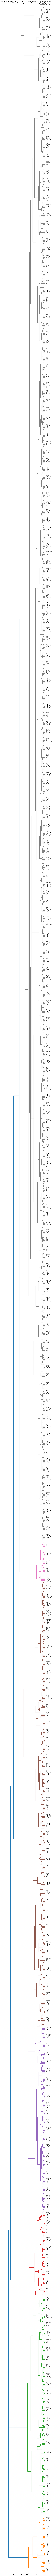

In [68]:
## term の階層クラスタリング: max_n_topics の値に拠ってparameters の最適値は異なる
HDP_helper.hc_clustering_terms_from_hdp (hdp45, diction, term_type = term_type, n_topics = 45, lowest_density = 0.0006, max_length = n_for_ngram, min_length = 2, gap_mark = gap_mark, sampling_rate = 0.3, check = False)

In [69]:
## HDP (n_topics = 90)
import gensim.models
import pyLDAvis.gensim

max_n_topics = 90
hdp90 = gensim.models.HdpModel(corpus, diction, T = max_n_topics,
                               random_state = 1)
vis_data90 = pyLDAvis.gensim.prepare(hdp90, corpus, diction)
pyLDAvis.display(vis_data90)

In [70]:
## save LDAvis output as a html file
#save_LDAvis = True
if save_LDAvis:
	lang_dir_name = target_lang_dict[target_lang_key].split()[0]
	vis_output = f"results/LDAvis/{lang_dir_name}/{target_lang_dict[target_lang_key]}{target_class}-HDP-max_ntop{max_n_topics}-{term_type}{accent_status}.html"
	pyLDAvis.save_html(vis_data90, vis_output)

In [71]:
## save topic structures
if save_topic_structure:
    hdp_topics = hdp90.show_topics(num_topics = max_n_topics,
                                num_words = n_terms_to_save, formatted = False)
    hdp_dict = { tid: values for tid, values in hdp_topics }

    ## convert to Pandas dataframe
    topics_df = pd.DataFrame.from_dict(hdp_dict)
    hdp90_topics_out = f"results/terms-by-topics-raw/{lang_dir_name}/{target_lang_dict[target_lang_key]}{target_class}-topics{max_n_topics}-{term_type}{accent_status}.csv"
    topics_df.to_csv(hdp90_topics_out, header = False, index = None)
    print(f"saved: {hdp90_topics_out}")

In [72]:
## topic investigation
import numpy as np
import HDP_helper

target_hdp = hdp90
documents_topics = np.zeros([target_hdp.m_T, len(corpus)])
for doc_id, c in enumerate(corpus):
    for topic_id, prob in target_hdp[c]:
        documents_topics[topic_id][doc_id] = prob

## investigate topics
target_hdp.optimal_ordering()
for topic_id, probs in enumerate(documents_topics):
    print(f"==============")
    #topic_encoding = ", ".join(hdp.show_topic(topic_id))
    topic_t = target_hdp.print_topic(topic_id, topn = n_terms_to_show)
    print(f"topic_id {topic_id}: {HDP_helper.reformat_topic (topic_t, n_terms_to_show)}")
    print(f"nonzero count: ", len(probs.nonzero()[0]))
    for doc_id in probs.argsort()[::-1][:n_docs_to_show]:
        doc = doc_dict[doc_id]
        print(f"\t{probs[doc_id]:0.4f}: {doc}")

topic_id 0: 0.0 * #d…a + 0.0 * #…r…n…# + 0.0 * #d…a…# + 0.0 * r…o# + 0.0 * de…a + 0.0 * a…e…a + 0.0 * #…a…l + 0.0 * #…r…o# + 0.0 * a…o…a + 0.0 * #…d…a + 0.0 * #…r…d + 0.0 * a…r…a + 0.0 * d…n + 0.0 * #…a…l…# + 0.0 * de…a…# + 0.0 * h…a + 0.0 * #…c…o + 0.0 * #…r…e# + 0.0 * l…a# + 0.0 * #…n…o…#
nonzero count:  677
	0.9992: #carriolas#
	0.9991: #carrilana#
	0.9991: #barrenado#
	0.9991: #anheladas#
	0.9990: #hondearan#
	0.9989: #doblonada#
	0.9989: #desyemase#
	0.9989: #aladrería#
	0.9988: #tranviero#
	0.9988: #afiliarme#
	0.9987: #desapoyan#
	0.9986: #falsearlo#
	0.9986: #escopeto#
	0.9986: #vallados#
	0.9985: #tachosas#
topic_id 1: 0.001 * r…m + 0.001 * r…m…# + 0.001 * r…os + 0.001 * mos + 0.001 * #…mo + 0.001 * r…os# + 0.0 * #…mos# + 0.0 * mos# + 0.0 * #…mos + 0.0 * a…os# + 0.0 * #…mo…# + 0.0 * r…m…s# + 0.0 * r…m…s + 0.0 * #…e…os# + 0.0 * #…e…os + 0.0 * e…os# + 0.0 * #…r…os# + 0.0 * e…os + 0.0 * #…r…os + 0.0 * re…o
nonzero count:  191
	0.9984: #timbraren#
	0.9984: #libreamos#
	0.9984: #ma

5695 rows remain after density filtering, discarding 94305 rows
5691 rows remain after size filtering, discarding 4 rows
1707 rows remain after size filtering, discarding 3984 rows


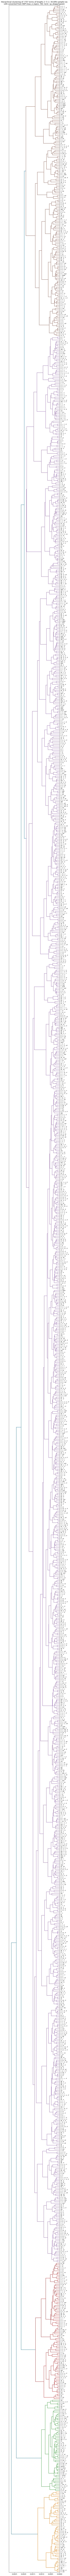

In [73]:
## term の階層クラスタリング: max_n_topics, term の値に拠ってparameters の最適値は異なる
HDP_helper.hc_clustering_terms_from_hdp (hdp90, diction, term_type = term_type, n_topics = 90, lowest_density = 0.0012, max_length = n_for_ngram, min_length = 2, gap_mark = gap_mark, sampling_rate = 0.3, check = False)